In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
# Change this to the path where this folder is located in your Drive
os.chdir('/content/drive/My Drive/masterarbeit/xgboost/framework')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install shap
!pip install pickle5
!pip install bayesian_optimization
!pip install lightgbm

In [ ]:
import pickle5
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Train

## Load all models

In [ ]:
from models.MLModel import MLModel
from models.FCNNModel import FCNNModel
from models.LGBMModel import LGBMModel
from models.XGBoostModel import XGBoostModel
from models.KNNModel import KNNModel
from models.SVMModel import SVMModel
from models.MaskNetModel import MaskNetModel
from models.ResNetModel import ResNetModel
from models.EnsembleModel import EnsembleModel

# Load data
Set i = 0 for loading data without reinforcement, i = 1 with reinforcement.

In [ ]:
i = 0

In [ ]:
X_train, X_val, X_test = np.load('data/X_train'+str(i)+'_prepro.npy', allow_pickle=True)[:, 1:], np.load('data/X_val'+str(i)+'_prepro.npy', allow_pickle=True)[:, 1:], np.load('data/X_test'+str(i)+'_prepro.npy', allow_pickle=True)[:, 1:]

In [ ]:
y_train, y_val, y_test = np.load('data/y_train'+str(i)+'_prepro.npy', allow_pickle=True)[:, 1:], np.load('data/y_val'+str(i)+'_prepro.npy', allow_pickle=True)[:, 1:], np.load('data/y_test'+str(i)+'_prepro.npy', allow_pickle=True)[:, 1:]

In [ ]:
def standardize(X:np.array, X_ref:np.array) -> np.array:
    return (X - X_ref.mean(axis=0)) / (X_ref.std(axis=0) + (X_ref.std(axis=0)==0).astype(int))

### Standardize all feature except one-hot encoded (first 11 features)

In [ ]:
X_val = np.hstack([X_val[:, :11], standardize(X_val[:, 11:], X_train[:, 11:])])
X_test = np.hstack([X_test[:, :11], standardize(X_test[:, 11:], X_train[:, 11:])])
X_train = np.hstack([X_train[:, :11], standardize(X_train[:, 11:], X_train[:, 11:])])
y_train, y_val, y_test = standardize(y_train, y_train), standardize(y_val, y_train), standardize(y_test, y_train)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(295171, 18)
(74014, 18)
(74015, 18)


## Load trained models

In [ ]:
fcnn = FCNNModel('fcnn')
resnet = ResNetModel('resnet')
masknet_small = MaskNetModel('masknet_small')
masknet_big = MaskNetModel('masknet_big')
lgbm = LGBMModel('lgbm')

In [ ]:
fcnn.load_model('experiments/fcnn_1_5_256')
resnet.load_model('experiments/resnet_1_5_256')
masknet_small.load_model('experiments/masknet_1_5_128')
masknet_big.load_model('experiments/masknet_1_12_128')
lgbm.load_model('experiments/lgbm_1')

## Define ensemble model

In [ ]:
ensembler = LGBMModel(name='ensembler_lgbm')

In [ ]:
model = EnsembleModel([fcnn, resnet, masknet_small, masknet_big, lgbm], ensembler)

## Train

In [ ]:
model.train(X_train, y_train, X_val, y_val, bayesian_optimization=True)

## Save

In [ ]:
model.save_model('experiments/ensemble_lgbm')

# Evaluate

In [ ]:
IN_VAR_NAMES  = ['Material Model Nr. '+str(i) for i in range(6)]+['CMM Usermat Model '+str(i) for i in range(5)] + ['Reinforcement Area',
                'Reinforcement Diameter','Effective Reinforcement TCM',
                'Reinforcement Angle','Normal Strain X',
                'Normal Strain Y','Shear Strain XY']

OUT_VAR_NAMES = ['Normal Stress in X-Direction $\sigma_x$', 'Normal Stress in Y-Direction $\sigma_y$',
                'Normal Stress in XY-Direction $\sigma_{xy}$', 'Stiffness Tensor Component $K_{11}$',
                'Stiffness Tensor Component $K_{12}$', 'Stiffness Tensor Component $K_{13}$',
                'Stiffness Tensor Component $K_{21}$', 'Stiffness Tensor Component $K_{22}$', 
                'Stiffness Tensor Component $K_{23}$', 'Stiffness Tensor Component $K_{31}$',
                'Stiffness Tensor Component $K_{32}$', 'Stiffness Tensor Component $K_{33}$']

In [ ]:
model.evaluate('experiments/ensemble_lgbm', X_test, y_test, in_var_names=IN_VAR_NAMES, out_var_names=OUT_VAR_NAMES)

## Create diagonal plots with positive, negative and mixed colored differently

In [ ]:
def show_diagonal_match(save_path:str, X:np.array, Y:np.array, predictions:np.array, plotname:str) -> None:
    ix_pos = []
    ix_neg = []
    ix_mix = []
    for i, x in enumerate(X):
        if x[-3] > 0 and x[-2] > 0 and x[-1] > 0:
            ix_pos.append(i)
        elif x[-3] < 0 and x[-2] < 0 and x[-1] < 0:
            ix_neg.append(i)
        else:
            ix_mix.append(i)
    plt.rcParams.update({'font.size': 28})
    plt.figure(figsize=[12, 10], dpi=100)
    plt.plot(Y[ix_pos], predictions[ix_pos], marker = 'o', ms = 10, linestyle='None', label='positive')
    plt.plot(Y[ix_neg], predictions[ix_neg], marker = '.', ms = 10, linestyle='None', label='negative')
    plt.plot(Y[ix_mix], predictions[ix_mix], marker = '3', ms = 10, linestyle='None', label='mixed')
    
    #plt.title(plotname)

    axa = plt.gca()
    axa.set_aspect('equal', 'box')
    axa.axis('square')
    axa.set_ylabel('Predicted '+ plotname)
    axa.set_xlabel('Reference '+ plotname)
    axa.set_xlim([np.min([np.min(Y), np.min(predictions)]), np.max([np.max(Y), np.max(predictions)])])
    axa.set_ylim([np.min([np.min(Y), np.min(predictions)]), np.max([np.max(Y), np.max(predictions)])])
    axa.grid(True, which='major', color='#666666', linestyle='-')
    # plt.plot([np.min([np.min(Y), np.min(predictions)]), np.max([np.max(Y), np.max(predictions)])], [np.min([np.min(Y), np.min(predictions)]), np.max([np.max(Y), np.max(predictions)])], linestyle='--',
    #             linewidth = 7)
    # plt.tight_layout()
    plt.legend()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, 'diagonal_match_'+plotname), dpi=400, bbox_inches='tight')
    plt.show()

    print('performance on positive:', np.mean((p[ix_pos]-y_test[ix_pos])**2))
    print('performance on negative:', np.mean((p[ix_neg]-y_test[ix_neg])**2))
    print('performance on mixed   :', np.mean((p[ix_mix]-y_test[ix_mix])**2))

Create predictions

In [ ]:
p = model.predict(X_test)

Set j to the index of the output feature to be examined.

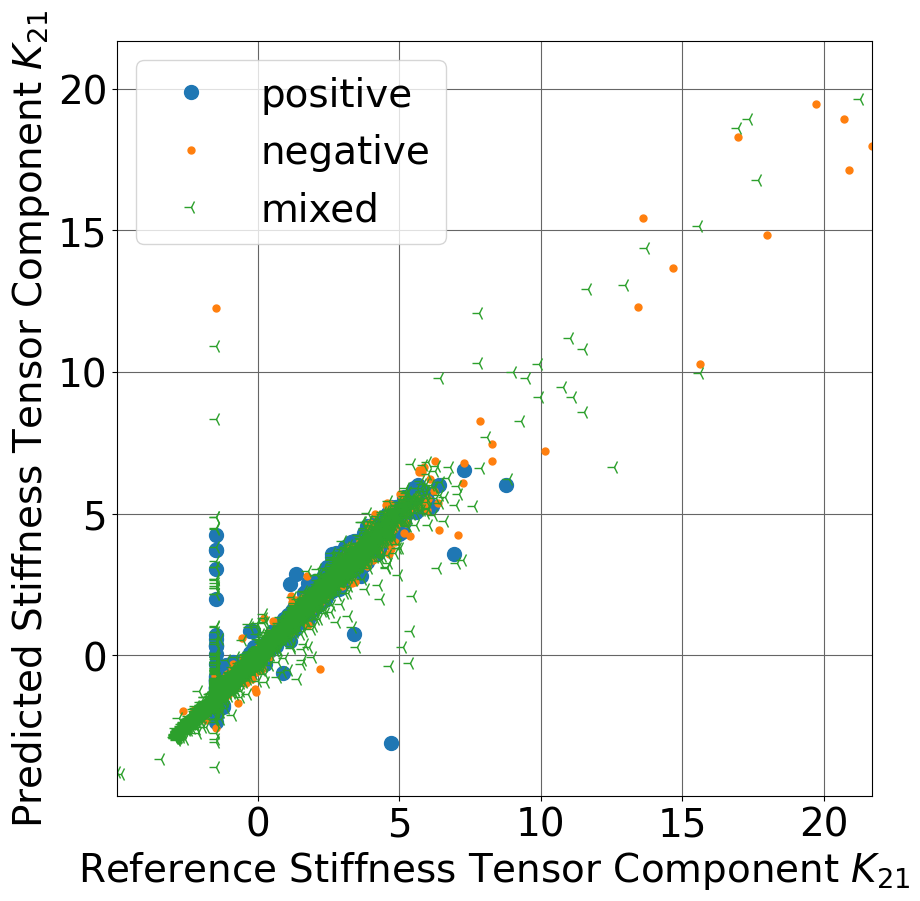

In [ ]:
j = 6
show_diagonal_match(None, X_test, y_test[:, j], p[:, j], OUT_VAR_NAMES[j])

## Compare models

In [ ]:
import matplotlib.pyplot as plt
markers = ['1', '2', '3', '4', 'x', 'o']

Set k to output feature to be examined.

In [ ]:
k = 0

[<lightgbm.basic.Booster object at 0x7f5cf17d4b90>, <lightgbm.basic.Booster object at 0x7f5cf17d48d0>, <lightgbm.basic.Booster object at 0x7f5cf1263a10>, <lightgbm.basic.Booster object at 0x7f5cf0a93dd0>, <lightgbm.basic.Booster object at 0x7f5cfdf36410>, <lightgbm.basic.Booster object at 0x7f5cf186ecd0>, <lightgbm.basic.Booster object at 0x7f5cf1850d10>, <lightgbm.basic.Booster object at 0x7f5cf1a2ded0>, <lightgbm.basic.Booster object at 0x7f5cf0dbfd10>, <lightgbm.basic.Booster object at 0x7f5cf17e9c90>, <lightgbm.basic.Booster object at 0x7f5cf0a01dd0>, <lightgbm.basic.Booster object at 0x7f5cf09fdd10>]


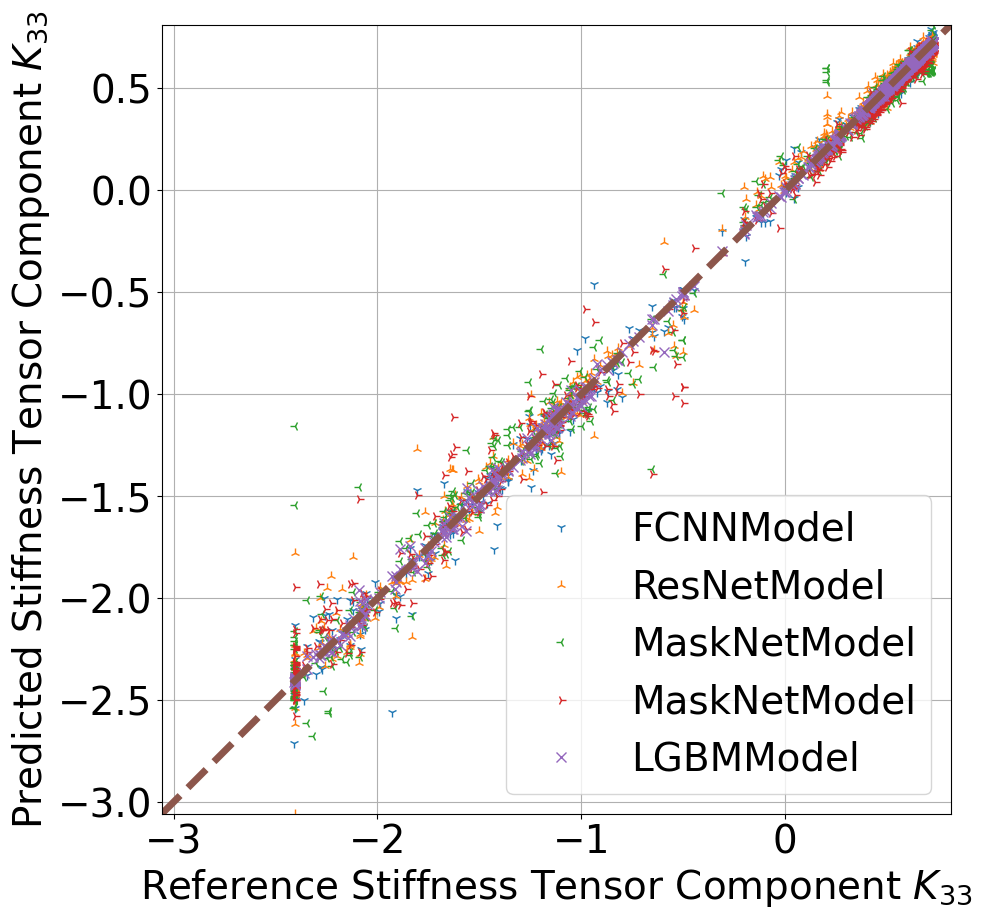

In [ ]:
i = 11
mini = 1e7
maxi = -1e7
plt.figure(figsize=[12, 10], dpi=100)
for l, m in enumerate(model.base_models):
    pred = m.predict(X_test[:1000])[:, k]
    if np.min(pred) < mini:
        mini = np.min(pred)
    if np.max(pred) > maxi:
        maxi = np.max(pred)
    plt.plot(y_test[:1000, k], pred, marker = markers[l], ms = 7, linestyle='None', label=m.__class__.__name__)

axa = plt.gca()
axa.set_aspect('equal', 'box')
axa.axis('square')
axa.set_ylabel('Predicted '+ OUT_VAR_NAMES[k])
axa.set_xlabel('Reference '+ OUT_VAR_NAMES[k])
axa.set_xlim([np.min([np.min(y_test[:1000, k]), mini]), np.max([np.max(y_test[:1000, k]), maxi])])
axa.set_ylim([np.min([np.min(y_test[:1000, k]), mini]), np.max([np.max(y_test[:1000, k]), maxi])])
axa.grid(True, which='major', linestyle='-')
plt.plot([np.min([np.min(y_test[:1000, k]), mini]), np.max([np.max(y_test[:1000, k]), maxi])], [np.min([np.min(y_test[:1000, k]), mini]), np.max([np.max(y_test[:1000, k]), maxi])], linestyle='--',
            linewidth = 5)
plt.legend()
plt.tight_layout()
plt.show()